In [1]:
from sklearn import datasets
import numpy as np
iris = datasets.load_iris()
X = iris.data[:,[2,3]]
y = iris.target
print('Class labels:', np.unique(y))

Class labels: [0 1 2]


In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1,stratify=y # We are splitting between training set and test set.
)                                                  # Note that the test set is 30% of the total dataset.

**NOTES:**
- Setting a fixed random seed in `random_state` allows reproduceability of the experiment;
- Stratify with `y` passed as a parameter means that it will put inside the training and test sets the same proportion of labels.

In [3]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
# Here we are standardizing the training and the test set features

# Creating a perceptron with Scikit-learn

In [4]:
from sklearn.linear_model import Perceptron

# Training
ppn = Perceptron(eta0=0.1,random_state=1)
ppn.fit(X_train_std,y_train)

# Predicting
y_pred = ppn.predict(X_test_std)
print('Misclassified examples: %d' % (y_test != y_pred).sum())

Misclassified examples: 1


# Accuracy
The classification accuracy of a model is calculated as follows: $1-errorPercentage$

In [5]:
from sklearn.metrics import accuracy_score
print('Accuracy: %.3f' % accuracy_score(y_test,y_pred))
print('Accuracy: %.3f' % ppn.score(X_test_std,y_test)) # Alternatively

Accuracy: 0.978
Accuracy: 0.978


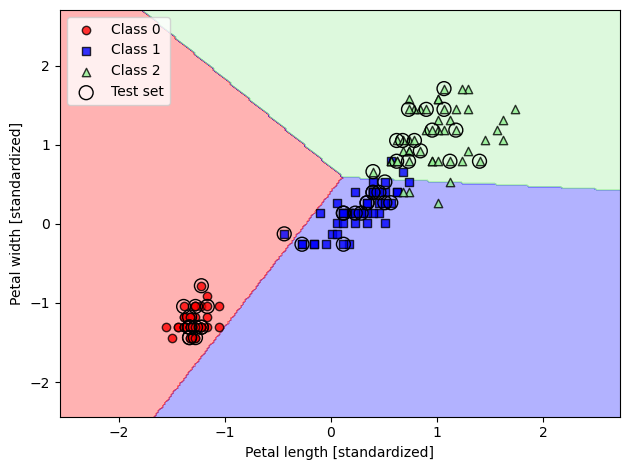

In [6]:

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
def plot_decision_regions(X: np.ndarray,y: np.ndarray, classifier, test_idx=None, resolution: float = 0.02):
    markers = ('o','s','^','v','<')
    colors = ('red','blue','lightgreen','gray','cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    x1_min, x1_max = X[:,0].min() - 1, X[:,0].max() + 1 # extracting min and max for the first feature
    x2_min, x2_max = X[:,1].min() - 1, X[:,1].max() + 1 # extracting min and max for the second feature
    
    """
    Everything until the contour function (comprehended) it's used to generate a list of dots in the surface, to use to make
    predictions. Those predictions will be used by the contour function to create contour regions.
    """
    xx1, xx2 = np.meshgrid(
        np.arange(x1_min,x1_max,resolution), # it makes a fake range of values, comprehended in the true range of the first feature
        np.arange(x2_min,x2_max,resolution) # it makes a fake range of values, comprehended in the true range of the second feature
    )
    # Practically speaking, the meshgrid makes it possible to evaluate the function (represented by the perceptron) on evenly
    # spaced (depending on the selected resolution) points.

    lab = classifier.predict(np.array([
        xx1.ravel(), # it makes the xx1 matrix in vector form (1 dimension, following the correct order)
        xx2.ravel() # it makes the xx2 matrix in vector form (1 dimension, following the correct order)
    ]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1,xx2, lab, alpha=0.3, cmap = cmap) # it draws contour areas based on the coordinates of a mesh grid
                                                       # - xx1 is the X axis
                                                       # - xx2 is the Y axis
                                                       # - lab is the Z axis (corresponding to the predictions)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # that's simply used to plot the single points of the different classes
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl,0],
                    y=X[y == cl,1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=f'Class {cl}',
                    edgecolors= 'black')

    # higlighting test examples
    if test_idx:
        X_test, y_test = X[test_idx,:], y[test_idx]

        plt.scatter(X_test[:,0],X_test[:,1],c='none',edgecolor='black',alpha=1.0,linewidth=1,marker='o',s=100,label='Test set')

X_combined_std = np.vstack((X_train_std,X_test_std)) # It stacks them vertically
y_combined = np.hstack((y_train,y_test)) # It stacks them horizontally

plot_decision_regions(X_combined_std,y_combined,classifier=ppn,test_idx=range(105,150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

**NOTE**: we are near-to-succesfully separating between 3 classes. However that's only possible because the model is implementing by itself (without us explicitly asking it) 3 perceptrons that are then combined to implement the ***One vs All*** strategy.

# Classifying with Logistic Regression
The perceptron has the limit that it will never converge if the classes are not perfectly linearly separable.

There is another algorithm for linear and binary classification problems, called logistic regression (it's a model for classification, not for regression).

The *sigmoid function* maps a real number between 0 and 1, giving the probability of an example given its features.
$$
    \sigma(z) = \frac{1}{1+e^{-z}}\\
     \\
    \text{where }z\text{ is: }w^T x + b
$$

<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
/var/folders/8q/dn061sy56s7b4yfppcpnhkqc0000gn/T/ipykernel_65543/986119440.py:12: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sigma (z)$')


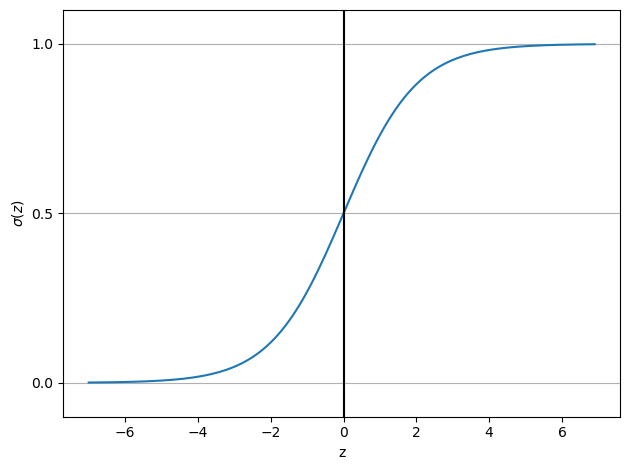

In [7]:
import numpy as np

def sigmoid(z: np.ndarray):
    return 1.0 / (1.0 + np.exp(-z))

z = np.arange(-7,7,0.1)
sigma_z = sigmoid(z)
plt.plot(z,sigma_z)
plt.axvline(0.0,color='k')
plt.ylim(-0.1,1.1)
plt.xlabel('z')
plt.ylabel('$\sigma (z)$')
plt.yticks([0.0,0.5,1.0])
ax = plt.gca()
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

In practice, we want the prediction to be 1 if we surpass the 50% probability:
$$
    \^y = \begin{cases}
                1 \text{ if } \sigma(z)\ge 0.5\\
                0 \text{ otherwise}
          \end{cases}
$$
Looking at the sigmoid function this means that:
$$
    \^y = \begin{cases}
                1 \text{ if } z\ge 0\\
                0 \text{ otherwise}
          \end{cases}
$$
We want to maximize the likelihood, that's defined like: $\mathcal{L}(w,b|x) = p(y|x;w,b)$.

Defined like that, this means that we want to maximize the probability that given the dataset $x$ and the parameters, we obtain the vector $y$ as a result.
To achieve that would like to maximize this equation:
$$
    \prod_{i=1}^n p(y^{(i)}|x^{(i)};w,b) = \prod_{i=1}^n (\sigma(z^{(i)}))^{y^{(i)}}(1 - \sigma(z^{(i)}))^{1-y^{(i)}}
$$
The derived loss function (to maximize) is as follows:
$$
    \sum_{i=1}[y^{(i)}\log(\sigma(z^{(i)})) + (1-y^{(i)})\log(1-\sigma(z^{(i)}))]
$$

Since we use the gradient descent optimizer, we put a $-$ before the loss funcion, because we want to arrive to the minimum.

<>:15: SyntaxWarning: invalid escape sequence '\s'
<>:15: SyntaxWarning: invalid escape sequence '\s'
/var/folders/8q/dn061sy56s7b4yfppcpnhkqc0000gn/T/ipykernel_65543/3785154285.py:15: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('$\sigma(z)$')


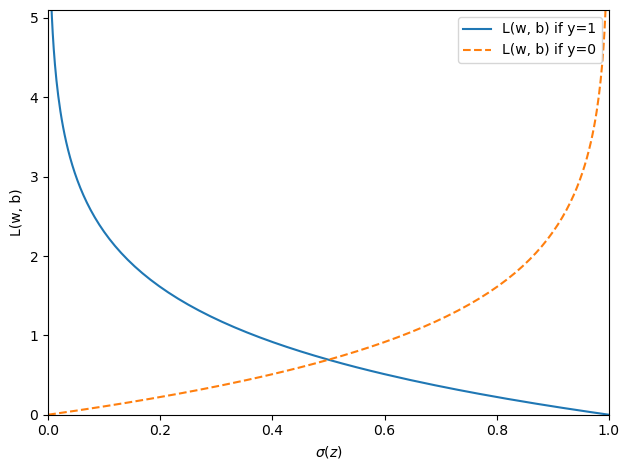

In [8]:
def loss_1(z: np.ndarray):
    return - np.log(sigmoid(z))

def loss_0(z: np.ndarray):
    return - np.log(1-sigmoid(z))

z = np.arange(-10,10,0.1)
sigma_z = sigmoid(z)
c1 = [loss_1(x) for x in z]
c0 = [loss_0(x) for x in z]
plt.plot(sigma_z, c1, label='L(w, b) if y=1')
plt.plot(sigma_z, c0,linestyle='--',label='L(w, b) if y=0')
plt.ylim(0.0,5.1)
plt.xlim([0, 1])
plt.xlabel('$\sigma(z)$')
plt.ylabel('L(w, b)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

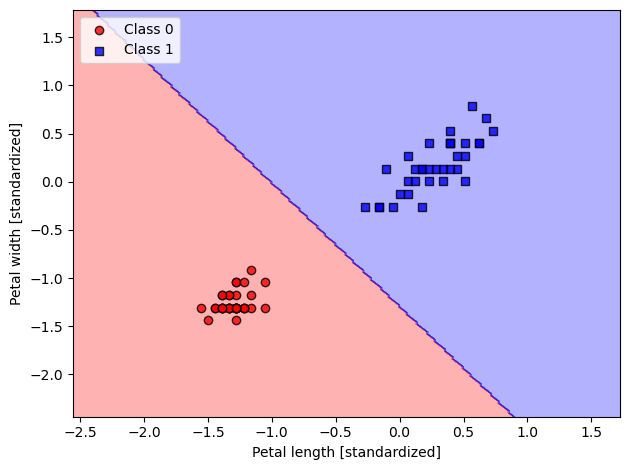

In [9]:
from LogisticRegressionGD import LogisticRegressionGD

X_train_01_subset = X_train_std[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]
lrgd = LogisticRegressionGD(eta=0.3,n_iter=1000,random_state=1)
lrgd.fit(X_train_01_subset,y_train_01_subset)
plot_decision_regions(X=X_train_01_subset,y=y_train_01_subset,classifier=lrgd)
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Logistic Regression with Scikit-Learn

/Users/riccardotoniolo/miniconda3/envs/mllib/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


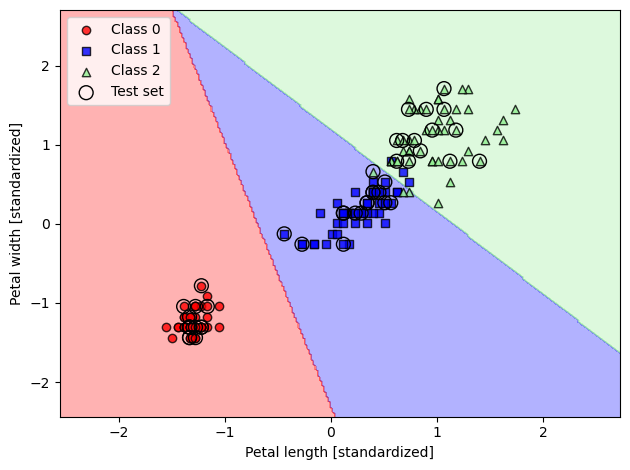

In [10]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=100.0,solver='lbfgs',multi_class='ovr')
# There are many solvers to choose from: 'newton-cg', 'lbfgs (default)', 'liblinear', 'sag', 'saga'
lr.fit(X_train_std,y_train)
plot_decision_regions(X=X_combined_std,y=y_combined,classifier=lr,test_idx=range(105,150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [11]:
lr.predict_proba(X_test_std[:3,:])

array([[6.63770505e-09, 1.44747233e-01, 8.55252760e-01],
       [8.34031210e-01, 1.65968790e-01, 3.20815954e-13],
       [8.48822884e-01, 1.51177116e-01, 2.57998350e-14]])

In [12]:
lr.predict_proba(X_test_std[:3,:]).argmax(axis=1)

array([2, 0, 0])

# Overfitting and regularization

- High bias is proportional to underfitting (the model it's too simple to capture teh pattern in the training data);
- High variance is proportional to overfitting (the model it's too complex, and it's so fitted on the training data that it does not generalize well on unseen data).

The most common way to tackle overfitting is to regularize: introducing additional information to penalize extreme parameter values.

This formula is to apply the **L2 regularization**:
$$
    \frac{\lambda}{2n}\|w\|^2 = \frac{\lambda}{2n}\sum_{j=1}^m w_j^2
$$

Here $\lambda$ is the so called *regularization parameter*.

Note that it only works on the weights of the features.

**IMPORTANT:** for regularization to work properly, we need to ensure that all our features are on comparable scales (that's why standardization is important).

The new loss function for logistic regression under regularization is the following:
$$
    \sum_{i=1}[y^{(i)}\log(\sigma(z^{(i)})) + (1-y^{(i)})\log(1-\sigma(z^{(i)}))] + \frac{\lambda}{2n}\|w\|^2
$$

because of that new term, the update for the weights will be:
$$
    \frac{\partial L(w,b)}{\partial w_j} = \bigl( \frac{1}{n}\sum_{i=1}^n (\sigma(w^Tx^{(i)})-y^{(i)})x_j^{(i)} \bigr) + \frac{\lambda}{n}w_j
$$

The `C` parameter in `LogisticRegression` from Scikit-Learn is inversely proportional to the regularization parameter. 

Making the `C` parameter smaller makes the regularization stronger.

/Users/riccardotoniolo/miniconda3/envs/mllib/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/riccardotoniolo/miniconda3/envs/mllib/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/riccardotoniolo/miniconda3/envs/mllib/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/riccardot

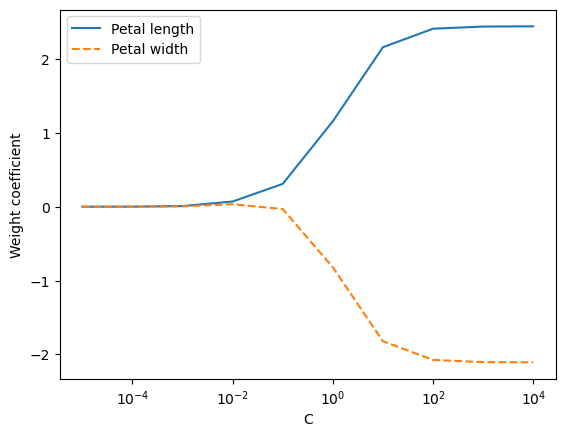

In [13]:
weights, params = [], []
for c in np.arange(-5,5):
    lr = LogisticRegression(C=10.**c,multi_class='ovr')
    lr.fit(X_train_std,y_train)
    weights.append(lr.coef_[1])
    params.append(10.**c)
    
weights = np.array(weights)
plt.plot(params, weights[:,0], label='Petal length')
plt.plot(params, weights[:,1], linestyle='--', label='Petal width')
plt.ylabel('Weight coefficient')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
plt.show()


We can clearly see here that if the regularization term is too strong, the model will perform poorly due to the weight being shrunk near to zero.

# Support Vector Machines - SVM

Here the optimization objective is to maximize the *margin*, where the margin is defined as the distance between the separating hyperplane (decision boundary) and the training examples that are closest to this hyperplane, which are so-called **support vectors**.

The rationale behind having decision boundaries with large margins is that they tend to have a lower generalization error, whereas models with small margins are more prone to overfitting.

Doe to the fact that many times different classes are not linearly separable, *slack-variables* were introduced. The motivation behind them was that the linear constraints in the SVM optimization objective need to be relaxed for nonlinearly separable data to allow the convergence of the optimization in the presence of misclassifications, under appropriate loss penalization.

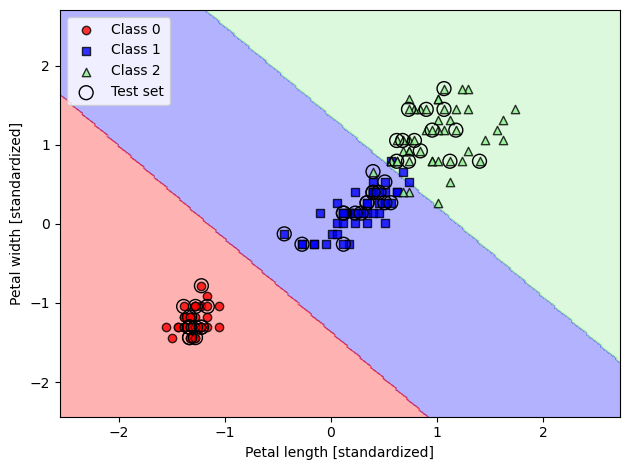

In [14]:
from sklearn.svm import SVC
svm = SVC(kernel='linear',C=1.0,random_state=1)
svm.fit(X_train_std,y_train)
plot_decision_regions(X_combined_std,y_combined,classifier=svm,test_idx=range(105,150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

Results between linear logistic regression and linear SVMs often yield very similar results, but:

Logistic regression:
 - Is more prone to outliers;
 - Simpler model;
 - Easily updatable, which is attractive when working with streaming data.

SVMs:
 - Less prone to outliers;
 - Generalizes better;
 - Far more complex.

One more thing: We can implement perceptrons, logistic regression algoritms and SVMs using:
```python
from sklearn.linear_model import SGDClassifier
ppn = SGDClassifier(loss='perceptron')
lr = SGDClassifier(loss='log')
svm = SGDClassifier(loss='hinge')
```
Using those implementations makes it possible to use online learning techniques that are not otherwise possible with previous discussed implementations (that are far more optimized, but they require the entire dataset to be stored in memory).

# Solving nonlinear problems using a kernel SVM

Kernel SVMs are the most famous variant of SVMs, and they are particularly used to tackle nonlinear problems (such as the xor problem).


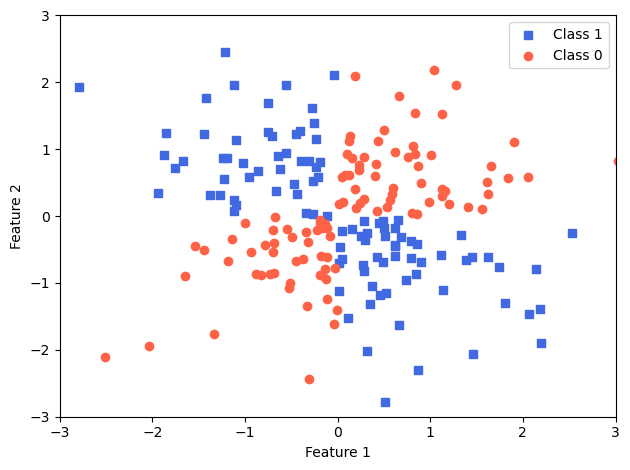

In [15]:
# Generating the dataset
np.random.seed(1)
X_xor = np.random.randn(200,2) # Here we will generate random numbers with normal distribution
y_xor = np.logical_xor(
    X_xor[:,0] > 0,
    X_xor[:,1] > 0
)
y_xor = np.where(y_xor, 1, 0)
plt.scatter(
    X_xor[y_xor == 1, 0],
    X_xor[y_xor == 1, 1],
    c='royalblue', marker='s',
    label='Class 1'
)
plt.scatter(
    X_xor[y_xor == 0, 0],
    X_xor[y_xor == 0, 1],
    c='tomato', marker='o',
    label='Class 0'
)
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# The kernel trick

What we want to achieve with kernels is to map the training data into higher-dimensional feature space via a mapping function $\phi$.
For example we want a behaviour similar to this:
$$
\phi(x_1,x_2) = (z_1,z_2,z_3) = (x_1,x_2,x_1^2+x_2^2)
$$
The problem resides in how SVMs work. Roughly speaking, using the kernel method, they require a dot product $x^{(i)T}x^{(j)}$ to be swapped with the dot product in the higher dimensional space: $\phi(x^{(i)})^T\phi(x^{(j)})$. This operation is called the _kernel function_.
The kernel function operation is really expensive though, so the _kernel trick_ comes in: we compute the result of that operation in the original dimensional space, like if the operation was done in the higher dimensional space and then mapped in the original one.
One of the most widely used kernels is the radial basis function (RBF), often called the Gaussian kernel:
$$
\kappa(x^{(i)},x^{(j)})=\exp(-\gamma||x^{(i)} - x^{(j)}||^2)
$$
where $\gamma$ is a free parameter to be optimized.
Roughly speaking, the term "kernel" can be interpreted as a similiarity function between a pair of examples.

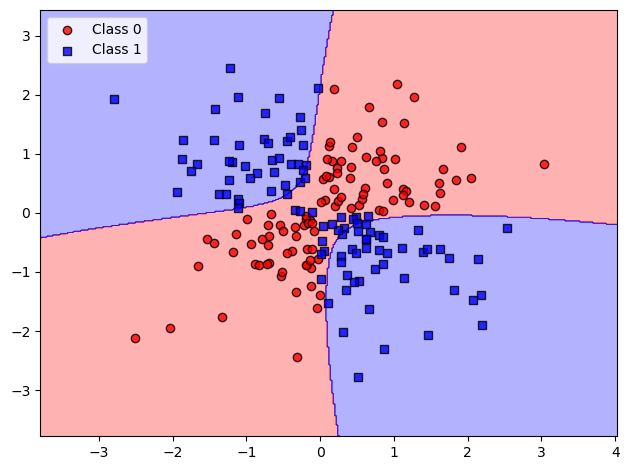

In [16]:
svm = SVC(kernel="rbf", C=10.0, gamma=0.10, random_state=1)
svm.fit(X_xor, y_xor)
plot_decision_regions(
    X_xor, y_xor, classifier=svm
)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

Let's now apply RBF to the flowers problem

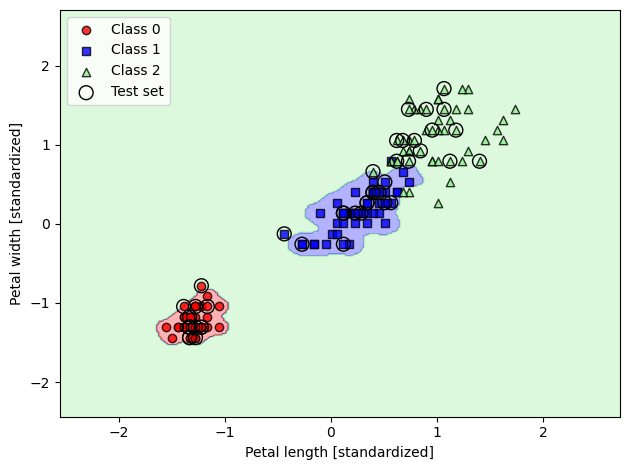

In [22]:
svm = SVC(kernel="rbf", gamma=100,C=1.0, random_state=1) # As we can see, having a bigger gamma determines tighter decision boundaries.
svm.fit(X_train_std, y_train)
plot_decision_regions(
    X_combined_std, y_combined, classifier=svm, test_idx=range(105, 150)
)
plt.xlabel("Petal length [standardized]")
plt.ylabel("Petal width [standardized]")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

# Decision tree learning
- Good if you care about interpretability;
- It builds a series of questions to guide a decision making process.

To create a tree though, we have to split the nodes a the most informative features.
We need to maximise the _Information Gain_ (IG) at each split, which we define as follows:
$$
IG(D_p,f) = I(D_p) - \sum_{j=1}^m\frac{N_j}{N_p}I(D_j)
$$
Here:
- $f$ is the feature to perform the split;
- $D_p$ and $D_j$ are the dataset of the parent and $j$ th child node;
- $I$ is the impurity measure;
- $N_i$ and $N_j$ are the total number of training examples at the parent node and the number of examples in the $j$ th child node.

As we can understand, the information gain is simply the difference between the impurity of the parent node and the sum of the child node impurities.
However, for simplicity and to reduce the combinatorial search space, most libraries implement binary decision trees, wich means that each parent node is split into two child nodes, $D_{left}$ and $D_{right}$:
$$
IG(D_p,f) = I(D_p) - \frac{N_{left}}{N_p}I(D_{left}) - \frac{N_{right}}{N_p}I(D_{right})
$$
The three impurity measures or splitting criteria that are commonly used in binary decision trees are:
 - Gini impurity;
 - Entropy;
 - Classification error.

Entropy:
$$
I_H(t) = - \sum_{i=1}^c p(i|t) \log_2 p(i|t) 
$$
Maximal coefficient with perfectly mixed classes.

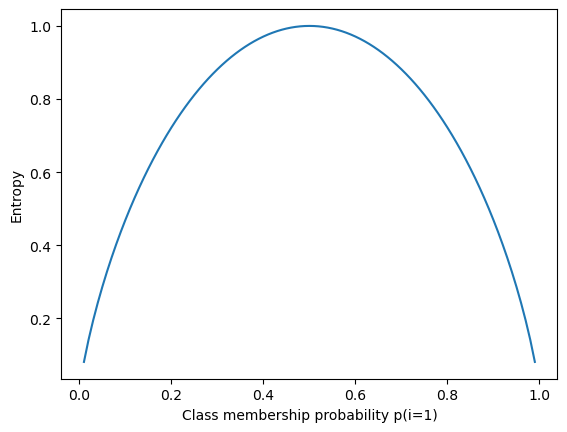

In [23]:
def entropy(p):
    return -p*np.log2(p) - (1-p)*np.log2(1-p)
x = np.arange(0.0, 1.0, 0.01)
ent = [entropy(p) if p != 0 else None for p in x]
plt.ylabel('Entropy')
plt.xlabel('Class membership probability p(i=1)')
plt.plot(x,ent)
plt.show()

Gini impurity:
$$
I_G(t) = \sum_{i=1}^c p(i|t)(1-p(i|t)) = 1 - \sum_{i=1}^c p(i|t)^2
$$
Maximal coefficient with perfectly mixed classes.

Classification error:
$$
I_E(t) = 1 - max{p(i|t)}
$$

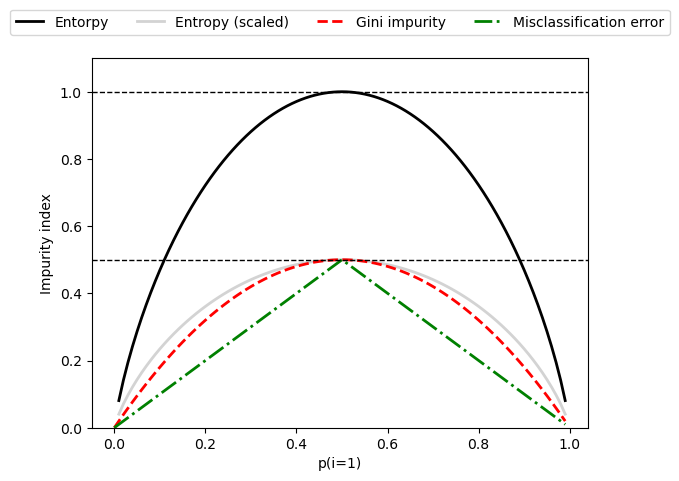

In [25]:
def gini(p):
    return p*(1-p) + (1-p)*(p)
def error(p):
    return 1 - max([p,1-p])
x = np.arange(0.0,1.0,0.01)
ent = [entropy(p) if p!=0 else None for p in x]
sc_ent = [e*0.5 if e else None for e in ent]
err = [error(i) for i in x]
fig = plt.figure()
ax = plt.subplot(111)
for i, lab, ls, c in zip([ent, sc_ent, gini(x), err],['Entorpy', 'Entropy (scaled)', "Gini impurity", "Misclassification error"],["-","-","--","-."],["black","lightgray","red","green","cyan"]):
    line = ax.plot(x,i,label=lab,linestyle=ls, lw=2, color=c)
ax.legend(loc="upper center", bbox_to_anchor=(0.5,1.15),ncol=5, fancybox=True, shadow=False)
ax.axhline(y=0.5,linewidth=1,color='k',linestyle='--')
ax.axhline(y=1.0,linewidth=1,color='k',linestyle='--')
plt.ylim([0,1.1])
plt.xlabel('p(i=1)')
plt.ylabel('Impurity index')
plt.show()

You can observe how entropy and gini impurity are pretty similar if the former is properly scaled.

## Building a decision tree

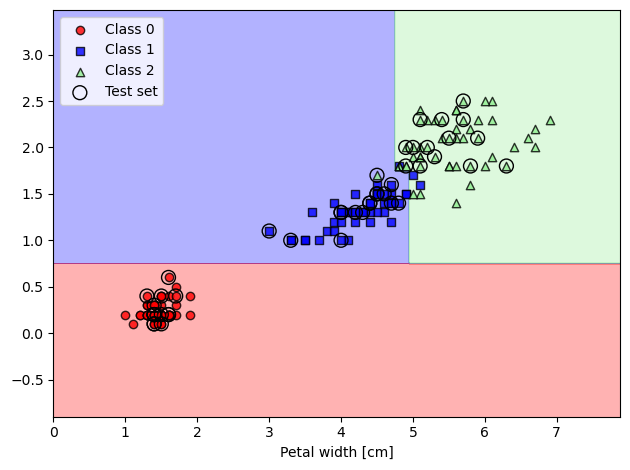

In [35]:
from sklearn.tree import DecisionTreeClassifier
tree_model = DecisionTreeClassifier(criterion='gini',max_depth=4,random_state=1)
tree_model.fit(X_train,y_train)
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined, y_combined,classifier=tree_model, test_idx=range(105,150))
plt.xlabel("Petal length [cm]")
plt.xlabel("Petal width [cm]")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

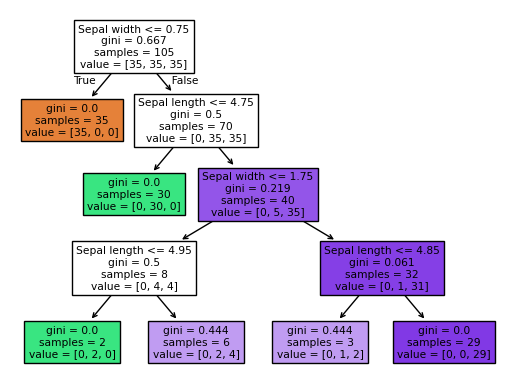

In [36]:
from sklearn import tree
feature_names = ['Sepal length',"Sepal width","Petal length", "Petal width"]
tree.plot_tree(tree_model,feature_names=feature_names,filled=True)
plt.show()

## Combining multiple decision trees via random forests